In [1]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd
import shutil

import numpy as np
import argparse
import matplotlib.pyplot as plt

from scipy import interpolate
import seaborn as sns
import starbars
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

from scipy.signal import savgol_filter, medfilt
from towbintools.foundation.utils import interpolate_nans

from plotting_functions import combine_experiments
from plotting_functions import plot_aggregated_series, plot_correlation, plot_correlation_at_ecdysis, boxplot_at_molt, plot_growth_curves_individuals, plot_deviation_from_model_at_ecdysis, plot_normalized_proportions, plot_deviation_from_model

# make warnings happen only once
import warnings
warnings.filterwarnings("once")


In [2]:
filemap_paths = [
    "/mnt/towbin.data/shared/igheor/20230502_Ti2_10x_vhp-1_338-345-344-186_25C_20230502_191744_431/analysis/report/analysis_filemap.csv",
    "/mnt/towbin.data/shared/igheor/20230727_Ti2_10x_vhp-1_345_344_338_186_160_20230727_191238_745/analysis/report/analysis_filemap.csv",
    "/mnt/towbin.data/shared/igheor/20230914_Ti2_10x_vhp-1_338_344_186_160_20230914_172832_008/analysis/report/analysis_filemap.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/igheor/20230502_Ti2_10x_vhp-1_338-345-344-186_25C_20230502_191744_431/doc/conditions.yaml",
    "/mnt/towbin.data/shared/igheor/20230727_Ti2_10x_vhp-1_345_344_338_186_160_20230727_191238_745/doc/conditions.yaml",
    "/mnt/towbin.data/shared/igheor/20230914_Ti2_10x_vhp-1_338_344_186_160_20230914_172832_008/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/vhp1_delta_plots/"
filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
    output_name = f"analysis_filemap_{i}.csv"
    output_name_config = f"config_{i}.yaml"
    
    # Copy the filemap to the backup path
    shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
    shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# Copy the current working directory to the backup path
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)
destination = os.path.join(backup_path, current_dir_name)

shutil.copytree(current_dir, destination, dirs_exist_ok=True)

print("Backup completed successfully!")

Backup completed successfully!


In [4]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

In [5]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}")

Condition: (0, {'col-10:TIR, no IAA'})
Condition: (1, {'vhp-1:delta, col-10:TIR, no IAA'})
Condition: (2, {'col-10:TIR, 500 uM IAA'})
Condition: (3, {'vhp-1:delta, col-10:TIR, 500 uM IAA'})
Condition: (4, {'vhp-1:delta, no TIR, 500 uM IAA'})
Condition: (5, {'vhp-1:delta, no TIR, no AID, 500 uM IAA'})
Condition: (6, {'no TIR, 500 uM IAA'})


In [79]:
# order conditions by auxin concentration
conditions_struct = sorted(conditions_struct, key=lambda x: x["auxin_concentration"])
# reassign the condition ids
for i, condition in enumerate(conditions_struct):
    condition["condition_id"] = i

for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}")

Condition: (0, {'col-10:TIR, no IAA'})
Condition: (1, {'vhp-1:delta, col-10:TIR, no IAA'})
Condition: (2, {'col-10:TIR, 500 uM IAA'})
Condition: (3, {'vhp-1:delta, col-10:TIR, 500 uM IAA'})
Condition: (4, {'vhp-1:delta, no TIR, 500 uM IAA'})
Condition: (5, {'vhp-1:delta, no TIR, no AID, 500 uM IAA'})
Condition: (6, {'no TIR, 500 uM IAA'})


In [80]:
print(conditions_struct[0].keys())

dict_keys(['auxin_concentration', 'strain', 'description', 'condition_id', 'ecdysis_time_step', 'larval_stage_durations_time_step', 'ecdysis_experiment_time', 'larval_stage_durations_experiment_time', 'experiment', 'body_seg_str_volume', 'body_seg_str_length', 'body_seg_str_worm_type', 'body_seg_str_volume_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_volume', 'pharynx_seg_str_length', 'pharynx_seg_str_worm_type', 'pharynx_seg_str_volume_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 'time', 'experiment_time'])


In [81]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

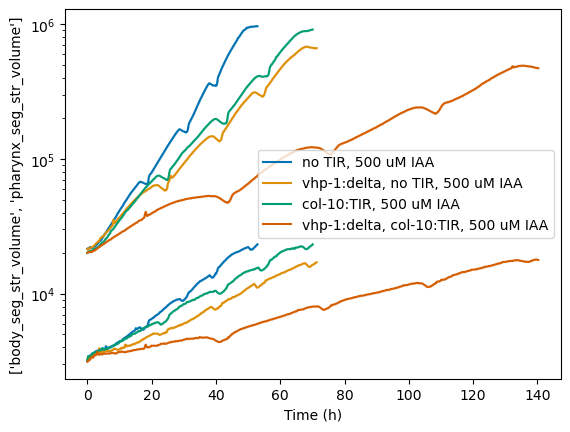

In [6]:
conditions_to_plot = [6, 4, 2, 3]
colors = None

plot_aggregated_series(conditions_struct, ['body_seg_str_volume', 'pharynx_seg_str_volume'], conditions_to_plot, colors=colors, experiment_time = False, aggregation='mean', n_points=100, time_step = 14, log_scale = True, legend = {'description': ''})

In [83]:
# conditions_to_plot = [0, 1, 3, 5, 7]
# colors = ['blue']
# colors += sns.color_palette("Blues", len(conditions_to_plot) - 1)

# plot_correlation(conditions_struct, 'body_seg_str_length', 'body_seg_str_volume', conditions_to_plot, log_scale = (False, True), legend = {'description': ''}, colors = colors)

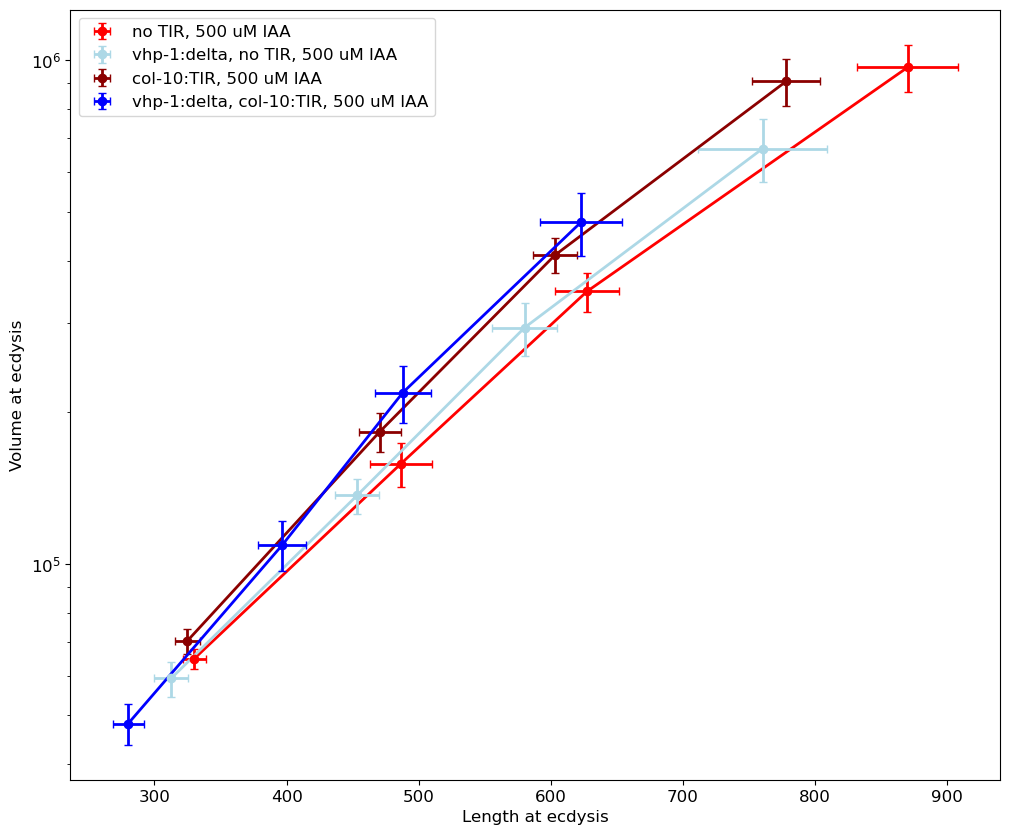

In [84]:
conditions_to_plot = [6, 4, 2, 3]
colors = ['red', 'lightblue', 'darkred', 'blue']


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Volume at ecdysis', x_axis_label='Length at ecdysis')

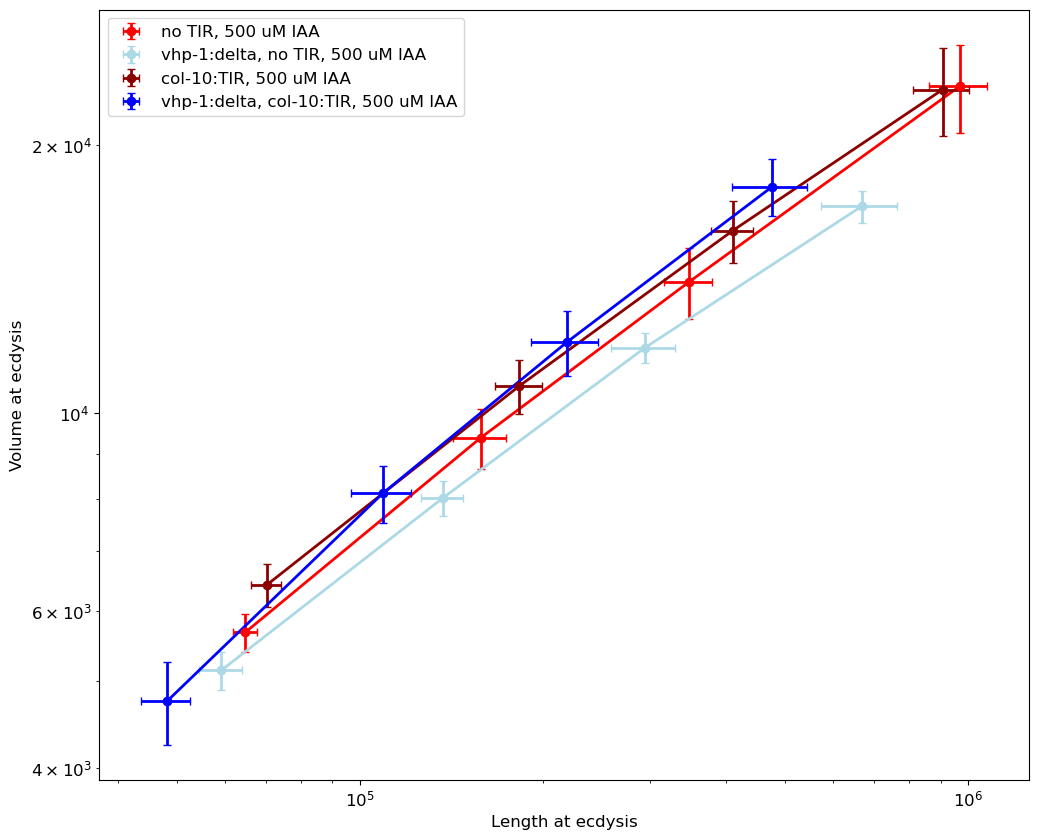

In [93]:
conditions_to_plot = [6, 4, 2, 3]
colors = ['red', 'lightblue', 'darkred', 'blue']


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, y_axis_label='Volume at ecdysis', x_axis_label='Length at ecdysis')

In [85]:
# boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

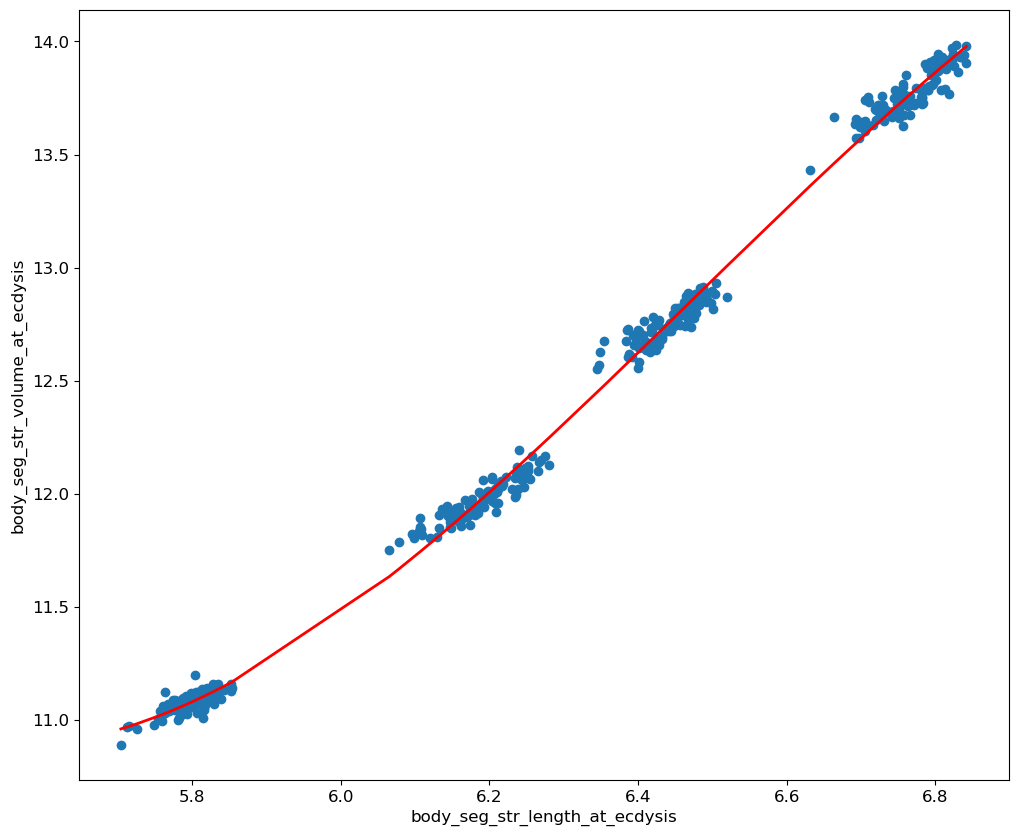

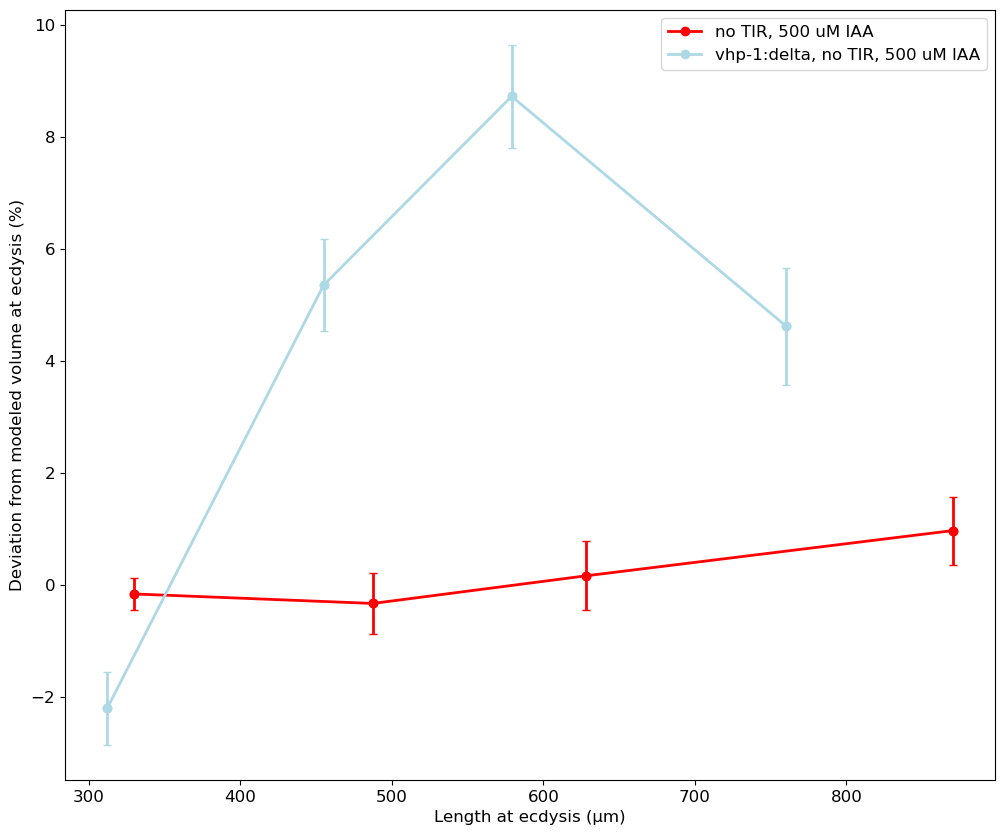

In [86]:
conditions_to_plot = [6, 4]
colors = ['red', 'lightblue', 'darkred', 'blue']

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_volume_at_ecdysis", 6, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled volume at ecdysis (%)')

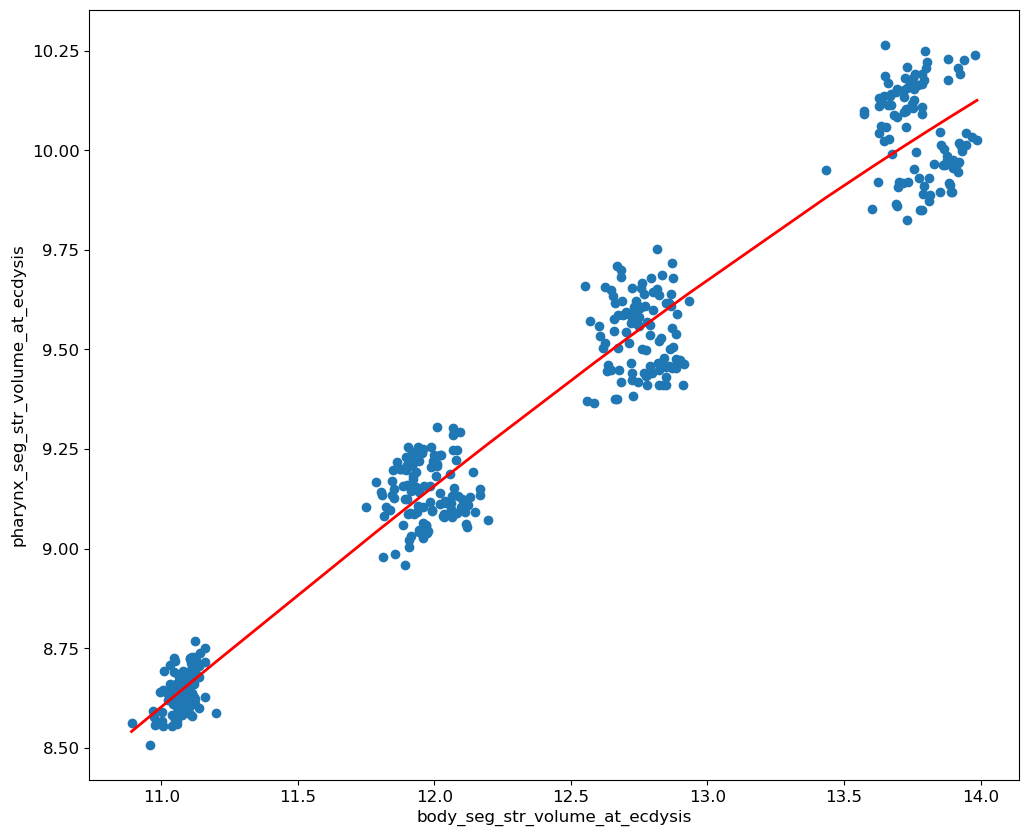

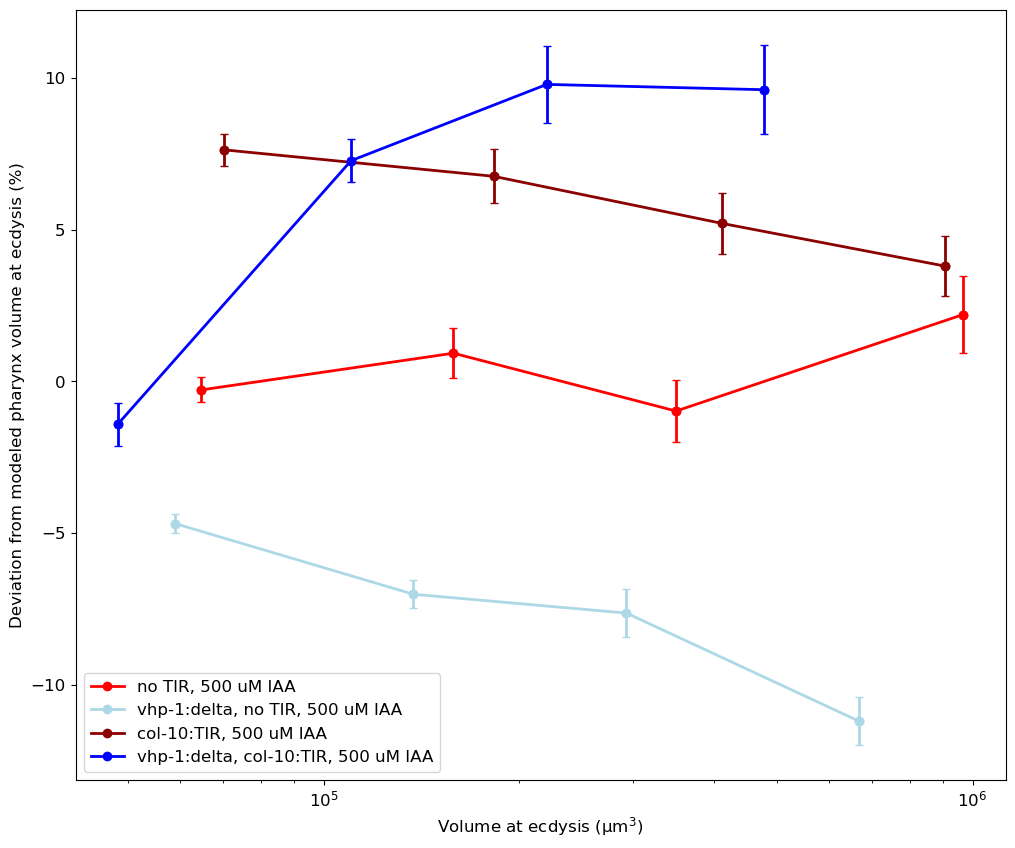

In [87]:
conditions_to_plot = [6, 4, 2, 3]
colors = ['red', 'lightblue', 'darkred', 'blue']

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_volume_at_ecdysis", "pharynx_seg_str_volume_at_ecdysis", 6, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Volume at ecdysis (µm$^3$)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

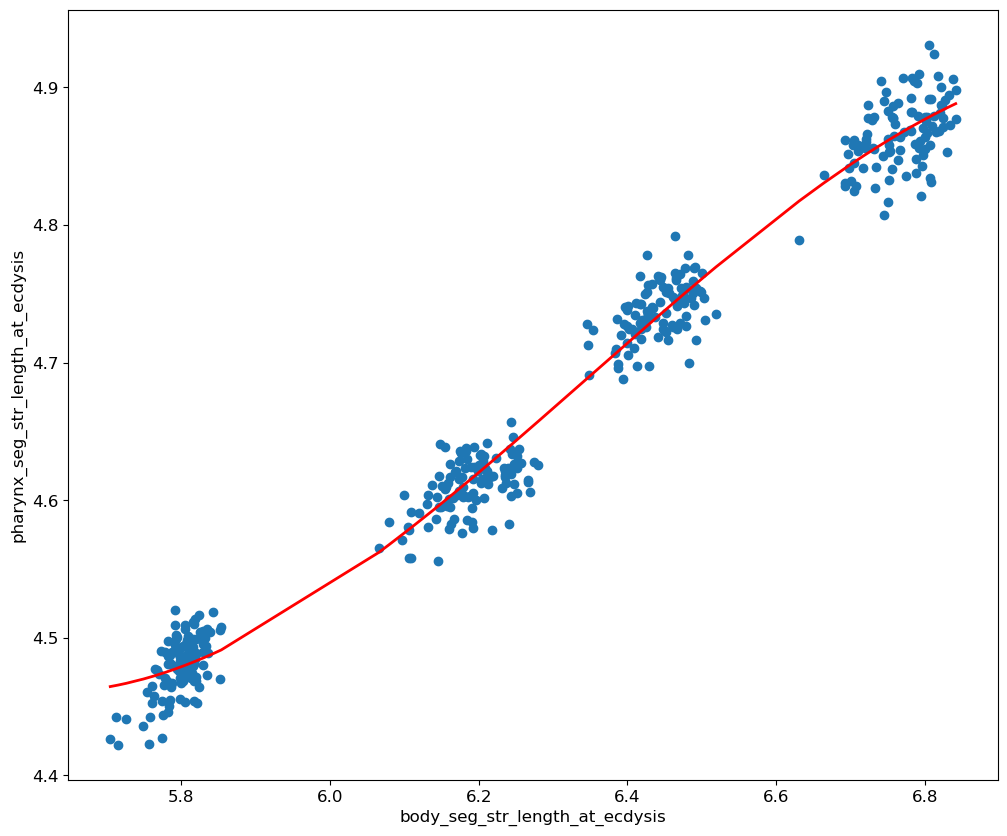

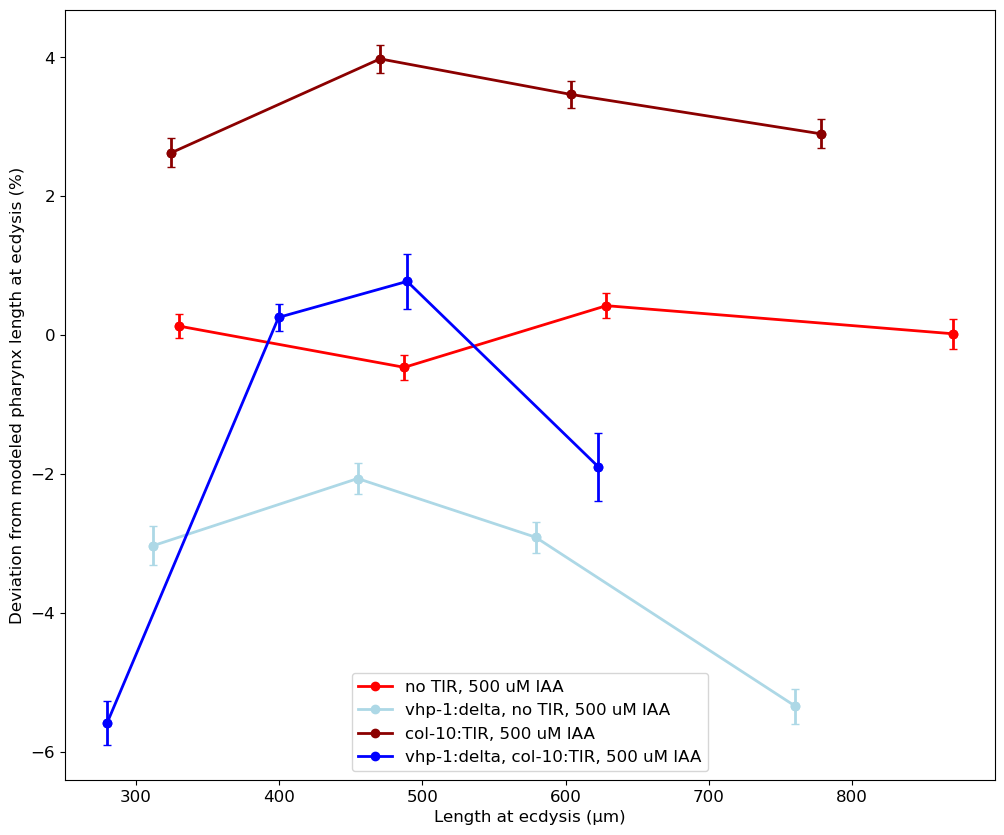

In [88]:
conditions_to_plot = [6, 4, 2, 3]
colors = ['red', 'lightblue', 'darkred', 'blue']


plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "pharynx_seg_str_length_at_ecdysis", 6, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (False, False), legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx length at ecdysis (%)')

/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


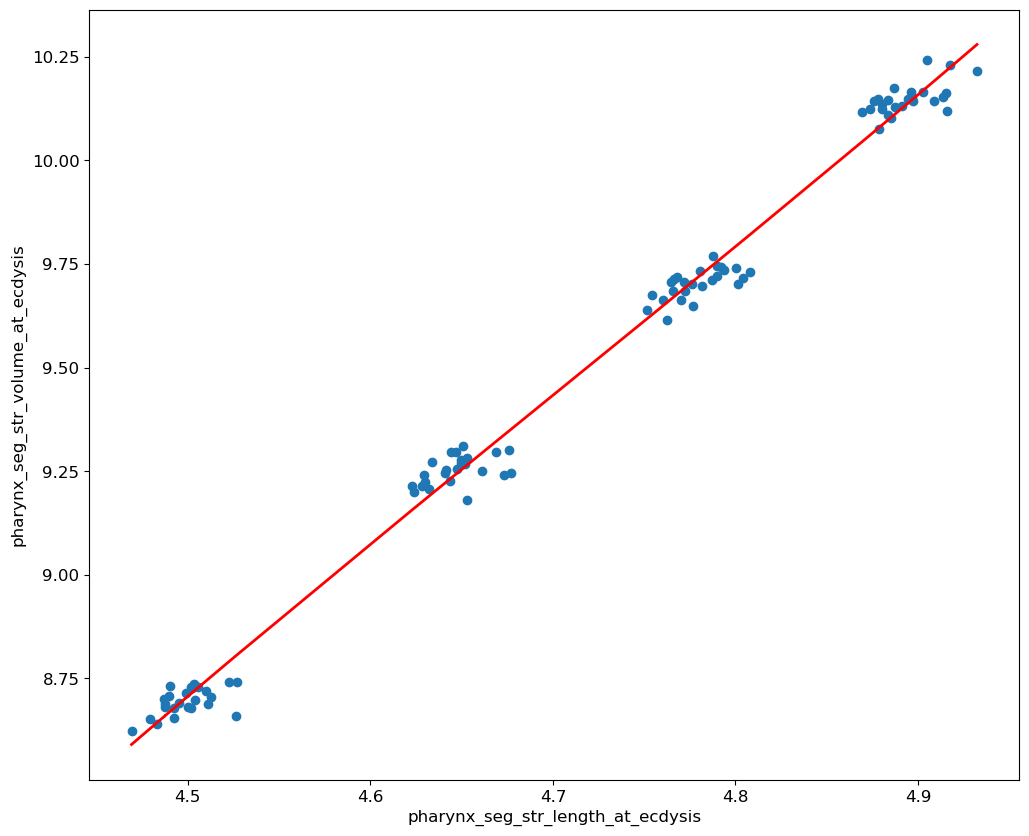

IndexError: list index out of range

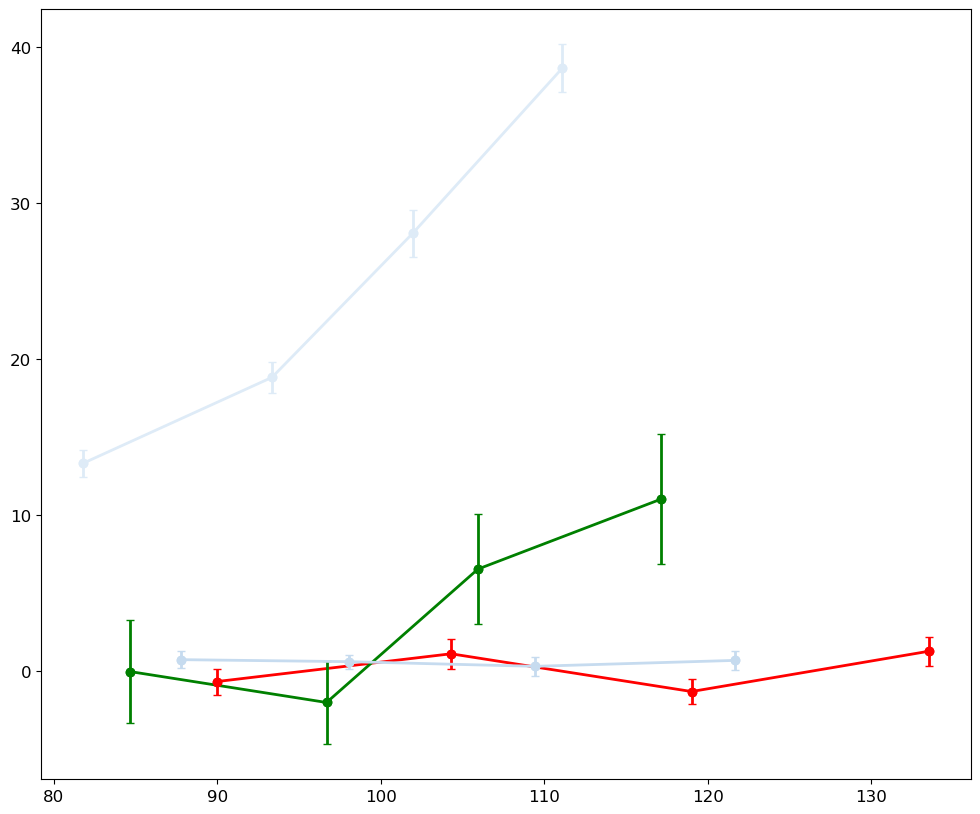

In [89]:
conditions_to_plot = [0, 1, 3, 5, 7, 9, 11, 13, 15]
colors = ['red', 'green']
colors += sns.color_palette("Blues", len(conditions_to_plot) - 2)


plot_deviation_from_model_at_ecdysis(conditions_struct, "pharynx_seg_str_length_at_ecdysis", "pharynx_seg_str_volume_at_ecdysis", 0, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (False, False), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

Removed 45 worms that did not complete development
Removed 21 worms that did not complete development
Removed 11 worms that did not complete development
Removed 14 worms that did not complete development


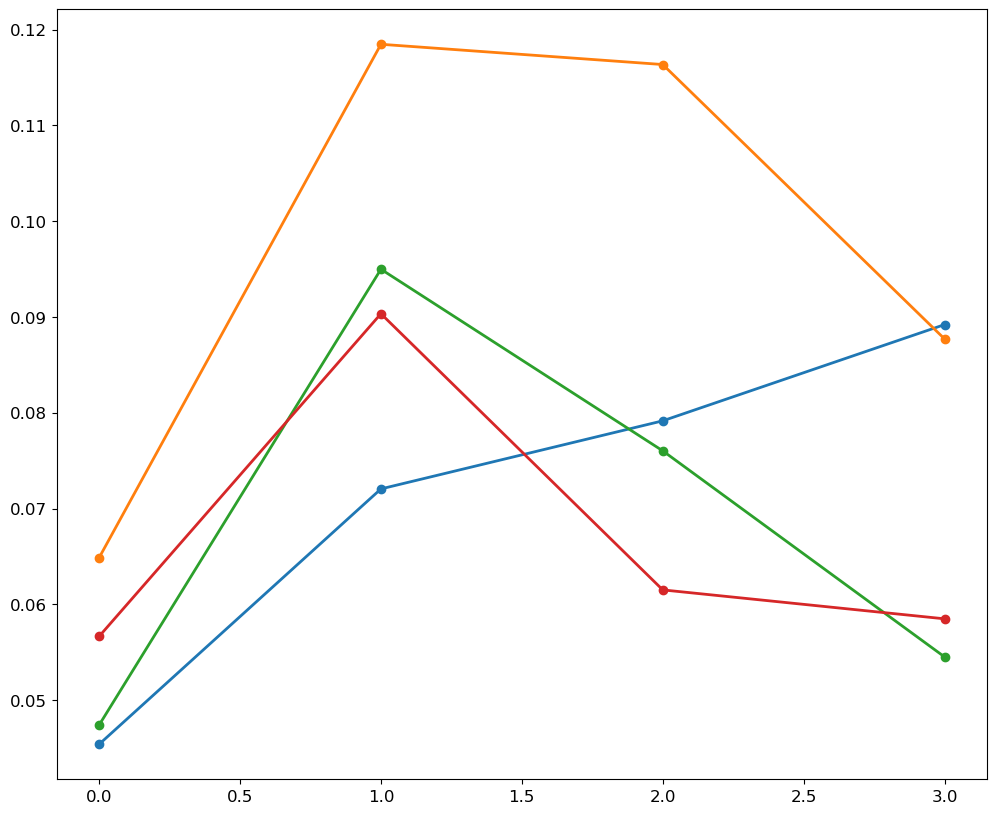

Removed 45 worms that did not complete development
Removed 21 worms that did not complete development
Removed 11 worms that did not complete development
Removed 14 worms that did not complete development


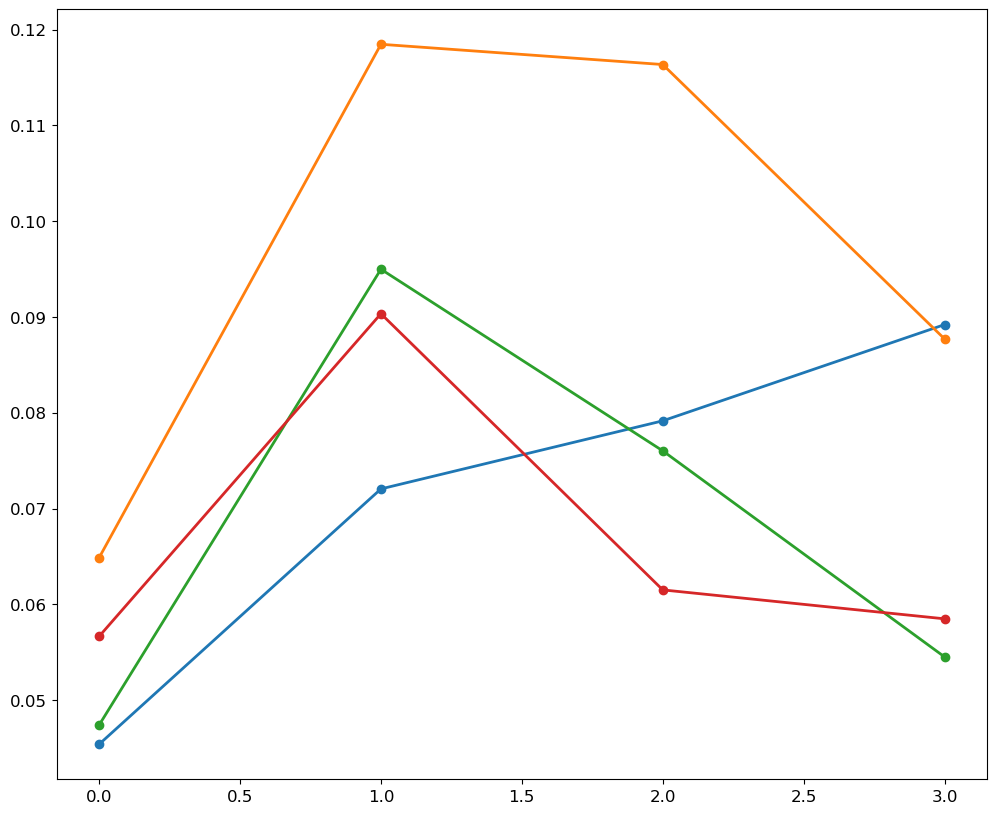

In [44]:
def plot_heterogeneity_at_ecdysis(conditions_struct, column, conditions_to_plot, remove_hatch = True, legend = None, x_axis_label = None, y_axis_label = None, keep_only_complete_development = False):
    for condition in conditions_to_plot:
        condition_dict = conditions_struct[condition]

        values = condition_dict[column]

        base_shape = values.shape[0]

        if remove_hatch:
            values = values[:, 1:]

        if keep_only_complete_development:
            values = values[~np.isnan(values).any(axis=1)]
            print(f"Removed {base_shape - values.shape[0]} worms that did not complete development")


        cvs = []
        for i in range(values.shape[1]):
            values_at_ecdysis = values[:, i]
            cv = np.nanstd(values_at_ecdysis) / np.nanmean(values_at_ecdysis)
            cvs.append(cv)

        plt.plot(cvs, label = condition_dict['description'], marker = 'o')
    plt.show()

plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [3, 2, 6, 10], legend = {'strain': ''}, keep_only_complete_development = True)   
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [3, 2, 6, 10], legend = {'strain': ''}, keep_only_complete_development = True)